In [2]:
import pandas as pd

# Lade den Datensatz
df = pd.read_csv("../../results/subset_10h/features_and_wer_10h_v3.csv")

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.4629 - mae: 1.5959 - mse: 4.4629 - val_loss: 0.1641 - val_mae: 0.3103 - val_mse: 0.1641
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3390 - mae: 0.8622 - mse: 1.3390 - val_loss: 0.1045 - val_mae: 0.2375 - val_mse: 0.1045
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7841 - mae: 0.6740 - mse: 0.7841 - val_loss: 0.0889 - val_mae: 0.2101 - val_mse: 0.0889
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5886 - mae: 0.5735 - mse: 0.5886 - val_loss: 0.0960 - val_mae: 0.2215 - val_mse: 0.0960
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4827 - mae: 0.5246 - mse: 0.4827 - val_loss: 0.0786 - val_mae: 0.2025 - val_mse: 0.0786
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4306 - mae: 0.4744 - mse: 0.4306 - val_loss: 0.0775 - val_mae: 0.1913 - val_mse: 0.0775
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3329 - mae: 0.4248 - mse

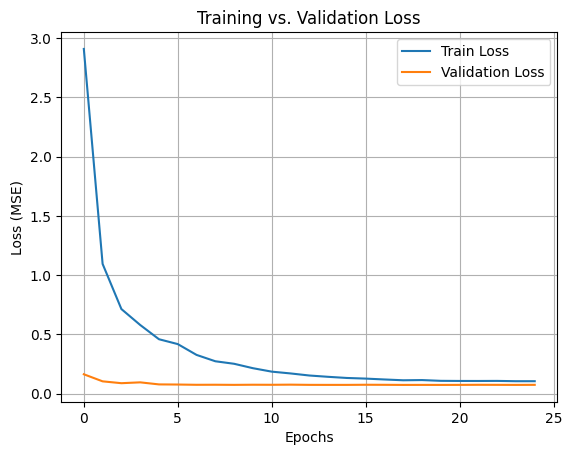

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Daten vorbereiten
exclude_cols = [
    "filename", "filepath", "reference",
    "hyp_tiny", "hyp_base", "hyp_small", "hyp_medium", "hyp_large",
    "wer_base", "wer_small", "wer_medium", "wer_large",
    "wer_tiny"
]

X = df.drop(columns=exclude_cols).select_dtypes(include='number')
y = df['wer_tiny']

# 2. Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. NaN oder Inf durch 0 ersetzen (falls nötig)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# 5. Modell definieren
model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)  # Regression: 1 Ausgang, keine Aktivierung
])

# 6. Kompilieren
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# 7. Frühes Stoppen
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 8. Training
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 9. Modellbewertung
loss, mae, mse = model.evaluate(X_test_scaled, y_test)
print(f"\nTest MAE: {mae:.4f} | Test MSE: {mse:.4f}")

# 10. Trainingsverlauf plotten
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² auf Testdaten: 0.0868


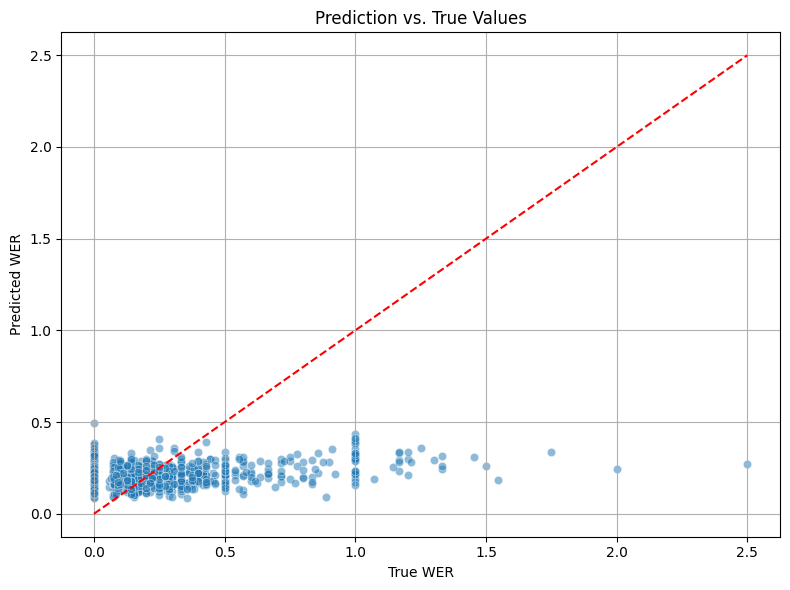

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Vorhersage auf Testdaten
y_pred = model.predict(X_test_scaled).flatten()

# R² auswerten
r2 = r2_score(y_test, y_pred)
print(f"R² auf Testdaten: {r2:.4f}")

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("True WER")
plt.ylabel("Predicted WER")
plt.title("Prediction vs. True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    # Bis zu 3 versteckte Schichten
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation=hp.Choice(f"activation_{i}", values=["relu", "tanh"])
        ))

    model.add(layers.Dense(1))  # Ausgangsschicht für Regression

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        ),
        loss="mse",
        metrics=["mae", "mse"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,  # reduziert Zufall
    directory='keras_tuner_dir',
    project_name='wer_tuning_v2'
)

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

best_model = tuner.get_best_models(1)[0]

loss, mae, mse = best_model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae:.4f} | Test MSE: {mse:.4f}")

Trial 50 Complete [00h 00m 31s]
val_loss: 0.10558327287435532

Best val_loss So Far: 0.07813041657209396
Total elapsed time: 00h 35m 00s
 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.1416 - mae: 0.2187 - mse: 0.1416

/opt/homebrew/Caskroom/miniconda/base/envs/ma-env/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0856 - mae: 0.1994 - mse: 0.0856  
Test MAE: 0.1987 | Test MSE: 0.0813


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² auf Testdaten: 0.0586


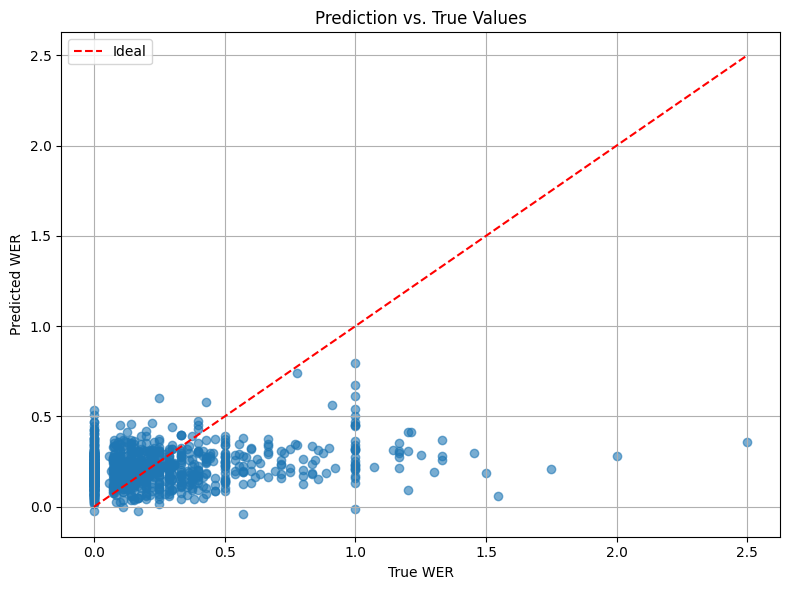

In [20]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Vorhersagen erzeugen
y_pred = best_model.predict(X_test_scaled).flatten()

# R² berechnen
r2 = r2_score(y_test, y_pred)
print(f"R² auf Testdaten: {r2:.4f}")

# Plot: Vorhersage vs. Wahre Werte
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Ideal')
plt.xlabel("True WER")
plt.ylabel("Predicted WER")
plt.title("Prediction vs. True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Zielvariable log-transformieren
y_raw = df['wer_tiny']
y_log = np.log1p(y_raw)  # log(1 + x) stabilisiert Ausreißer

# Relevante Features auswählen
exclude_cols = ["filename", "filepath", "reference",
                "hyp_tiny", "hyp_base", "hyp_small", "hyp_medium", "hyp_large",
                "wer_base", "wer_small", "wer_medium", "wer_large", "wer_tiny"]
X = df.drop(columns=exclude_cols).select_dtypes(include='number')

# Zusammenführen und Bereinigen
combined = pd.concat([X, y_log.rename("wer_tiny_log")], axis=1)
combined_clean = combined.replace([np.inf, -np.inf], np.nan).dropna()

# Wieder trennen
X = combined_clean.drop(columns="wer_tiny_log")
y_log = combined_clean["wer_tiny_log"]

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.0201 - mae: 0.7131 - mse: 1.0201 - val_loss: 0.0750 - val_mae: 0.2085 - val_mse: 0.0750
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0625 - mae: 0.1934 - mse: 0.0625 - val_loss: 0.0539 - val_mae: 0.1776 - val_mse: 0.0539
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0483 - mae: 0.1680 - mse: 0.0483 - val_loss: 0.0476 - val_mae: 0.1672 - val_mse: 0.0476
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0430 - mae: 0.1608 - mse: 0.0430 - val_loss: 0.0515 - val_mae: 0.1716 - val_mse: 0.0515
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0444 - mae: 0.1622 - mse: 0.0444 - val_loss: 0.0555 - val_mae: 0.1755 - val_mse: 0.0555
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0500 - mae: 0.1680 - mse: 0.0500 - val_loss: 0.0414 - val_mae: 0.1491 - val_mse: 0.0414
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0397 - mae: 0.1521 - mse: 0.0397 - val

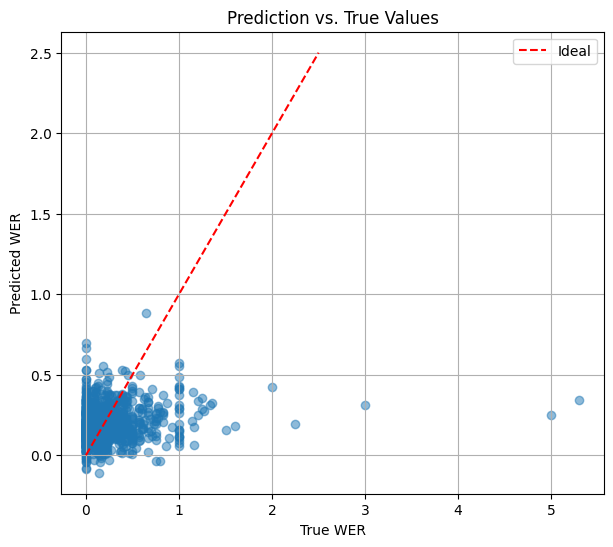

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Modell definieren
model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regressionsausgabe
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Training mit Early Stopping
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Auswertung
loss, mae, mse = model.evaluate(X_test_scaled, y_test)
print(f"\nTest MAE: {mae:.4f} | Test MSE: {mse:.4f}")

# R² berechnen
y_pred = model.predict(X_test_scaled).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² auf Testdaten: {r2:.4f}")

# Plot: Vorhersage vs. Wahrheit
plt.figure(figsize=(7, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([0, 2.5], [0, 2.5], 'r--', label='Ideal')
plt.xlabel("True WER")
plt.ylabel("Predicted WER")
plt.title("Prediction vs. True Values")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
    
    # Dense Layer 1
    model.add(layers.Dense(
        units=hp.Int('units1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('act1', ['relu', 'tanh'])
    ))

    # Dense Layer 2
    model.add(layers.Dense(
        units=hp.Int('units2', min_value=16, max_value=128, step=16),
        activation=hp.Choice('act2', ['relu', 'tanh'])
    ))

    # Output
    model.add(layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

# Tuner definieren
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='wer_prediction'
)

# Frühes Stoppen
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Tuning starten
tuner.search(X_train_scaled, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             callbacks=[early_stop],
             verbose=1)

# Bestes Modell laden
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Trial 30 Complete [00h 00m 23s]
val_loss: 0.058535732328891754

Best val_loss So Far: 0.03704937919974327
Total elapsed time: 00h 15m 07s
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.2848 - mae: 0.8852 - mse: 1.2848 - val_loss: 0.4142 - val_mae: 0.4970 - val_mse: 0.4142
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3097 - mae: 0.4337 - mse: 0.3097 - val_loss: 0.1856 - val_mae: 0.3283 - val_mse: 0.1856
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1500 - mae: 0.3016 - mse: 0.1500 - val_loss: 0.1182 - val_mae: 0.2585 - val_mse: 0.1182
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1096 - mae: 0.2477 - mse: 0.1096 - val_loss: 0.0878 - val_mae: 0.2202 - val_mse: 0.0878
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0800 - mae: 0.2127 - mse: 0.0800 - val_loss: 0.0728 - val_mae: 0.1991 - val_mse: 0.0728
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0645 - mae: 0.1914 - mse: 0.0645 - val_loss: 0.063

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0419 - mae: 0.1535 - mse: 0.0419

Test MAE: 0.1556 | Test MSE: 0.0450
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² auf Testdaten: 0.0423


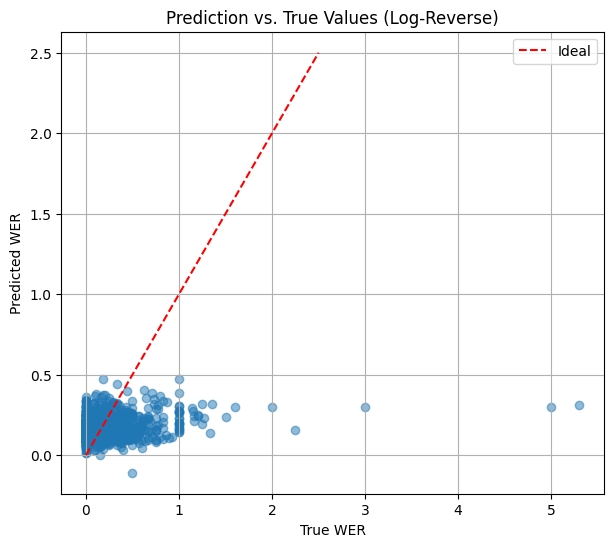

In [25]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Testdaten auswerten
loss, mae, mse = best_model.evaluate(X_test_scaled, y_test)
print(f"\nTest MAE: {mae:.4f} | Test MSE: {mse:.4f}")

# R² berechnen
y_pred = best_model.predict(X_test_scaled).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² auf Testdaten: {r2:.4f}")

# Plot: Vorhersage vs. Wahrheit (zurücktransformiert)
plt.figure(figsize=(7, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([0, 2.5], [0, 2.5], 'r--', label='Ideal')
plt.xlabel("True WER")
plt.ylabel("Predicted WER")
plt.title("Prediction vs. True Values (Log-Reverse)")
plt.legend()
plt.grid(True)
plt.show()